In [3]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

/mnt/raid/data/anina/ScanDy


If we want to run this notebook on Google Colab, we first have to install `ScanDy` and download the required dataset from Google drive. The following code cell will prepare all of this for us.

In [18]:
import numpy as np
import pickle
import seaborn as sns
import random
from scipy import stats
import matplotlib.pyplot as plt

import scandy_pfc.models.model as base_model 
import scandy_pfc.models.ObjectModel as objectmodel_module
import scandy_pfc.utils.dataclass as dataclass_module
import scandy_pfc.utils.functions as uf
import scandy_pfc.utils.pfc_eval as pfc
import importlib

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
import pandas as pd
import os
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple
import pandas as pd
from matplotlib.collections import PolyCollection
import pandas as pd
import pickle


In [ ]:
dircl = ['xkcd:maroon', sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6] ]
mcl = ['xkcd:blue', 'xkcd:red']
MODEL = "obj" 
FEATURESET = "DG2E_cb" 


In [5]:
importlib.reload(dataclass_module)
Dataset = dataclass_module.Dataset
importlib.reload(base_model)
importlib.reload(objectmodel_module)
ObjectModel = objectmodel_module.ObjectModel



# Model optimization and quantitative comparison

In this example, we show how we can find suitable parameters for a model with evolutionary optimization, such that models can be compared quantitatively. 

## Dataset and model initialization
The parameter optimization should be done on the training set, but for this example we demonstrate how to do this on a single video.

In [ ]:
folder_path = "/mnt/raid/data/anina/ScanDy/PictureExample/videos/"

# List all files (ignores subfolders)
files = [os.path.splitext(f)[0] for f in os.listdir(folder_path) 
         if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(".png")]

print(files)

['openDoorInside', 'phone', 'ballBalance', 'disinfectant', 'waterHose', 'catcafe', 'monitorLizard', 'trash', 'mokaPot', 'penDrawing', 'yoga', 'bottleString', 'robot', 'work', 'bed', 'kettle', 'bird', 'toytrain', 'giraffe', 'ventilator', 'openDoorOutside', 'shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2', 'candle', 'monkey2', 'statues', 'coffeeOnSofa', 'crow', 'blueBoiler', 'axolotl', 'rippingPaper', 'reindeers', 'billboard', 'lizard', 'plank', 'bigAnimalBackground', 'work2', 'dino', 'laundry', 'birdFalling', 'bikeUnlocking', 'heron', 'conversation', 'robot2', 'clock', 'crowBall', 'whiteBoard', 'trafficLight2', 'construction', 'gondolaUp', 'carStart', 'fingerTapping', 'chessBoard', 'stapler', 'elevatorWrongSide', 'lake', 'receipt', 'bench', 'teabagOut', 'toytrainHouses', 'sparkling2', 'espresso', 'skiLift', 'trafficLight', 'mail', 'watering', 'snip', 'selfie', 'shoot', 'throw', 'youtube']


In [6]:
#imglist = sorted(['openDoorInside', 'monitorLizard', 'trash', 'mokaPot', 'penDrawing', 'yoga', 'bottleString', 'robot', 'work', 'bed', 'kettle', 'bird', 'toytrain', 'giraffe', 'ventilator', 'openDoorOutside', 'shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2', 'candle', 'monkey2', 'statues', 'coffeeOnSofa', 'crow', 'blueBoiler', 'axolotl', 'rippingPaper', 'reindeers', 'billboard', 'lizard', 'plank', 'bigAnimalBackground', 'work2', 'dino', 'laundry', 'birdFalling', 'bikeUnlocking', 'heron', 'conversation', 'robot2', 'clock', 'crowBall', 'whiteBoard', 'trafficLight2', 'construction', 'gondolaUp', 'carStart', 'fingerTapping', 'chessBoard', 'stapler', 'elevatorWrongSide', 'lake', 'receipt', 'bench', 'teabagOut', 'toytrainHouses', 'sparkling2', 'espresso', 'skiLift', 'trafficLight', 'mail', 'watering', 'snip', 'selfie', 'shoot', 'throw', 'youtube'])
imglist = sorted(['shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2'])

random.seed(12345)
#trainlist = sorted(random.sample(imglist, 10))
trainlist = sorted(random.sample(imglist, 2))
testlist = sorted([vidname for vidname in imglist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)
print(len(trainlist), len(imglist))
datadict = {
    "PATH": "PictureExample/", 
    'FPS' : 30,
    'PX_TO_DVA' : (47.7 * 0.8) / 1920,
    'FRAMES_ALL_VIDS' : 150,
    'gt_foveation_df' : 'df_all_fovs_psycsci.csv',
    'NAME_COL' : 'scene', #<-- changed from 'video' to 'scene' from ScanDy to ScanDy with Pfc
    'trainset' : trainlist,
    'testset' : testlist,
    'used_videos': imglist
}
VidCom = Dataset(datadict)
# For faster processing during testing, resize the videos to smaller dimensions
VidCom.VID_SIZE_Y, VidCom.VID_SIZE_X = 540, 960

trainlist =  ['chimpanzee', 'shoebill'] 
testlist = ['elevatorEmpty', 'fish', 'fly', 'pedestrian', 'sealion', 'toaster', 'trinkvogel2', 'waterbottle', 'watercooler']
2 11
Video column is set to: scene


Only run it for a single model.

## Implement the fitness function

With this information, we can specify the model we want to investigate. The parameters are then selected for each run based on the evolutionary optimization strategy. 

But before we specify the parameter space, we define an optimization function, which we will pass to the `Evolution` class from `neurolib` (powered by the `deap` and `pypet` libraries).

We specify a fitness function $\mathcal{F}$ to evaluate how well the simulated scanpaths match the human data. In this example we evaluate each parameter configuration by compating the summary statistics of the saccade amplitude and foveation duration of the simulated scanpaths with the human ground truth using the Kolmogorov-Smirnov test.

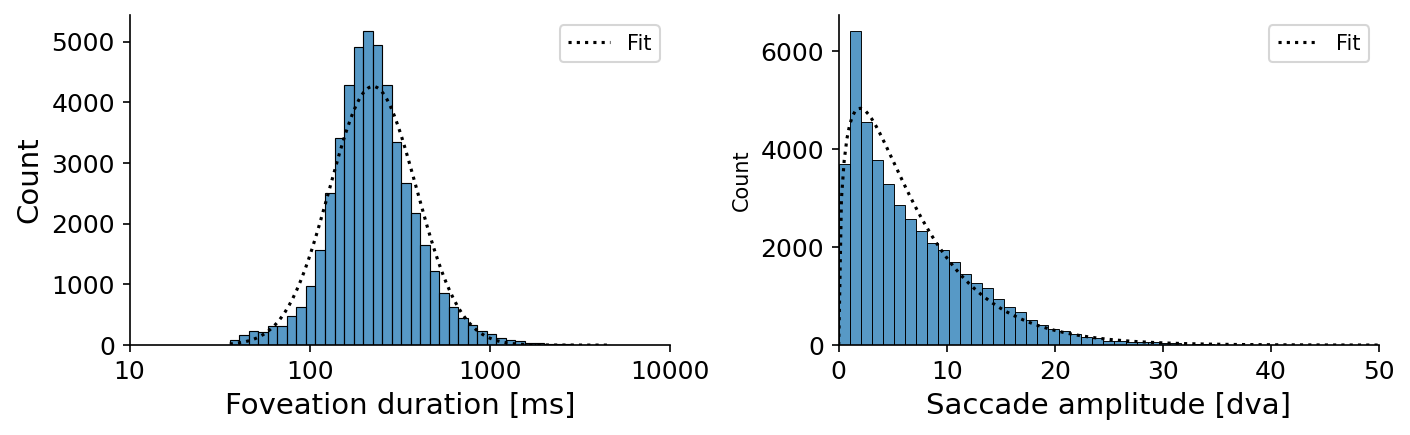

Foveation duration fit (log10 space): (2.3516607018819586, 0.2408009619000579)
Saccade amplitude fit: (1.4058227930166194, 0, 4.842505862212446)


In [7]:
# Ground truth 
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values

# Fit with Gamma-function for Saccade amplitude
ampX = np.linspace(0, 50, 200)
ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
ampPDF = stats.gamma.pdf(ampX, *ampfit)

# Fit with Log-normal approximation for Foveation duration
dur_log = np.log10(gt_dur_ms)
durX = np.linspace(dur_log.min(), dur_log.max(), 200)
durfit = stats.norm.fit(dur_log)
durPDF = stats.norm.pdf(durX, *durfit)

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9.5, 3), sharey=False)
bins_dur = 40
counts_dur, bin_edges_dur = np.histogram(dur_log, bins=bins_dur)
bin_width_dur = bin_edges_dur[1] - bin_edges_dur[0]
durPDF_scaled = durPDF * len(dur_log) * bin_width_dur

bins_amp = np.linspace(0, 50, 50)
counts_amp, bin_edges_amp = np.histogram(gt_amp_dva, bins=bins_amp)
bin_width_amp = bin_edges_amp[1] - bin_edges_amp[0]
ampPDF_scaled = ampPDF * len(gt_amp_dva) * bin_width_amp

sns.histplot(dur_log, bins=bins_dur, kde=False, ax=axs[0])
axs[0].plot(durX, durPDF_scaled, color='k', ls=':', label='Fit')
axs[0].set_xticks([1, 2, 3, 4])
axs[0].set_xticklabels([10, 100, 1000, 10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Count', size=14)
axs[0].tick_params(labelsize=12)
axs[0].legend()
sns.histplot(gt_amp_dva, bins=bins_amp, kde=False, ax=axs[1])
axs[1].plot(ampX, ampPDF_scaled, color='k', ls=':', label='Fit')
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].set_xlim([0, 50])
axs[1].tick_params(labelsize=12)
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()

print("Foveation duration fit (log10 space):", durfit)
print("Saccade amplitude fit:", ampfit)


This is implemented in the following optimization function, where the model is initialized in every run with the parameters selected by the evolutionary optimization strategy and then run for all videos in the training set (in our example just a single video).
The resulting scanpath(s) are then compared to the human data according to the fitness function $\mathcal{F}$ and the results are stored in the HDF file.

In [10]:
def optimize_me(traj):
    ind = evolution.getIndividualFromTraj(traj)
    # create model of the given model family
    if MODEL == "obj":
        model = ObjectModel(VidCom)
    else:
        raise Exception(f"The only implemented models here are obj and loc!")
    model.params["centerbias"] = "anisotropic_default"
    model.params["featuretype"] = FEATURESET
    # free model parameters, varied in evolution
    model.params["ddm_thres"] = ind.ddm_thres
    model.params["ddm_sig"] = ind.ddm_sig
    model.params["att_dva"] = ind.att_dva
    model.params["ior_decay"] = ind.ior_decay
    # IOR parameters depend on the model...
    if MODEL == "obj":
        model.params["ior_inobj"] = ind.ior_inobj
    else:
        model.params["ior_dva"] = ind.ior_dva

    # usually run model on all videos of the training set for multiple random seeds
    # model.run("train", seeds=[s for s in range(1, 13)])
    # ...but for demonstration purposes, we only run the model on one video once:
    model.run("axolotl", seeds=[s for s in [1]])

    model.evaluate_all_to_df()  # creates model.result_df
    sim_dur_ms = model.result_df["duration_ms"].dropna().values
    sim_amp_dva = model.result_df["sac_amp_dva"].dropna().values

    # evaluate fitness
    ks_amp, _ = stats.ks_2samp(gt_amp_dva, sim_amp_dva)
    ks_dur, _ = stats.ks_2samp(gt_dur_ms, sim_dur_ms)
    fitness_tuple = (ks_dur, ks_amp)

    # we can store more information in the HDF file by returning a dictionary
    res_dict = model.get_fovcat_ratio()
    
    return fitness_tuple, res_dict

## Specify parameters and run optimization

We can now specify the parameter space for the optimization. We use the `ParameterSpace` class from `neurolib` to give a range for all free model parameters.

In [12]:
obj_pars = ParameterSpace(
    ["ddm_thres", "ddm_sig", "att_dva", "ior_decay", "ior_inobj"],
    [[1.0, 3.0], [0.05, 0.25], [5, 20], [30, 300], [0.4, 1.0]],
)

Now we have everything set up to actually run the evolutionary optimization. As specified in `optimize_me`, we only run it for one video and one random seed. 

The processes are parallelized as much as your system allows for it. 

In [13]:
evolution = Evolution(
    optimize_me,
    obj_pars,
    weightList=[-1.0, -1.0], #weights foveation duration and saccade amplitude equally
    filename="ex2_obj_sglvid.hdf",
    POP_INIT_SIZE= 6, #64, #6 better: 64 candidate solutions created in the first generation
    POP_SIZE= 6, #32, #6 better: 32 individuals are kept or generated after selection and mutation in each generation
    NGEN=5, #50 #5 better: 50 for one video 30 seem enough
)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/ex2_obj_sglvid.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7f065eff5510>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7f065fc230a0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7f065eff5990>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7f065eff56c0>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7f065eff5750>


MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/ex2_obj_sglvid.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7f2a4b03f5b0>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7f2a4bcf11b0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7f2a4b03fa30>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7f2a4b03f760>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7f2a4b03f7f0>
MainProcess root INFO     Evaluating initial population of size 6 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.environ

MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     Starting multiprocessing with at most 256 processes running at the same time.
MainProcess pypet INFO     PROGRESS: Finished 0/6 runs [                    ]  0.0%


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)VID_SIZE_Y=540, VID_SIZE_X=960
Expected frames: 150

Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960VID_SIZE_Y=540, VID_SIZE_X=960
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)

Feature maps shape: (150, 540, 960)Feature maps shape: (150, 540, 960)Expected frames: 150


Expected frames: 150Expected frames: 150



MainProcess pypet INFO     PROGRESS: Finished 1/6 runs [===                 ] 16.7%, remaining: 0:01:53
MainProcess pypet INFO     PROGRESS: Finished 2/6 runs [======              ] 33.3%, remaining: 0:00:45
MainProcess pypet INFO     PROGRESS: Finished 3/6 runs [==========          ] 50.0%, remaining: 0:00:22
MainProcess pypet INFO     PROGRESS: Finished 4/6 runs [=============       ] 66.7%, remaining: 0:00:11
MainProcess pypet INFO     PROGRESS: Finished 5/6 runs [================    ] 83.3%, remaining: 0:00:04
MainProcess pypet INFO     PROGRESS: Finished 6/6 runs [====================]100.0%
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
***********************************************************

Parameter distribution (Generation 0):
ddm_thres: 	 mean: 2.3168,	 std: 0.5113
ddm_sig: 	 mean: 0.1602,	 std: 0.0697
att_dva: 	 mean: 11.0269,	 std: 2.0064
ior_decay: 	 mean: 129.8252,	 std: 51.0278
ior_inobj: 	 mean: 0.5325,	 std: 0.1451


MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
VID_SIZE_Y=540, VID_SIZE_X=960Feature maps shape: (150, 540, 960)

Expected frames: 150Feature maps shape: (150, 540, 960)

Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess pypet INFO     PROGRESS: Finished 7/12 runs [===========         ] 58.3%, remaining: 0:01:54
MainProcess pypet INFO     PROGRESS: Finished 8/12 runs [=============       ] 66.7%, remaining: 0:00:46
MainProcess pypet INFO     PROGRESS: Finished 9/12 runs [===============     ] 75.0%, remaining: 0:00:23
MainProcess pypet INFO     PROGRESS: Finished 10/12 runs [================    ] 83.3%, remaining: 0:00:11
MainProcess pypet INFO     PROGRESS: Finished 11/12 runs [==================  ] 91.7%, remaining: 0:00:04
MainProcess pypet INFO     PROGRESS: Finished 12/12 runs [====================]100.0%
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
**************************************************

----------- Generation 1 -----------
Best individual is [2.2253749492598573, 0.22955232055716351, 11.897475596977442, 79.05965961598832, 0.4118061538107591, 0.6666666666666666, 0.06666666666666667, 5.0, 90.0, 0.19999999999999998]
Score: -0.30217290709460237
Fitness: (0.20643449025150945, 0.3979113239376953)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2025-12-03-07H-57M-01S
Duration of evaluating initial population 0:00:24.737578
Eval function: <function optimize_me at 0x7f2a4ac98040>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 6
Population size: 6
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2a4bcf11b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f2a4b03f7f0>
Selection paramter: 

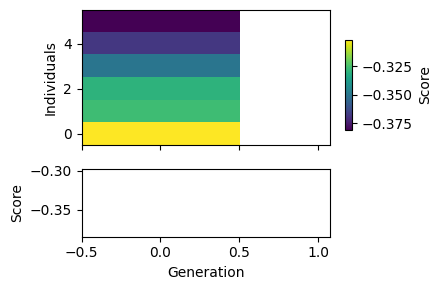

MainProcess root INFO     Saving plot to ./data/figures/results-2025-12-03-07H-57M-01S_hist_1.png


There are 6 valid individuals
Mean score across population: -0.34


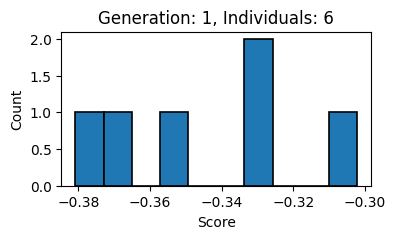

<Figure size 640x480 with 0 Axes>

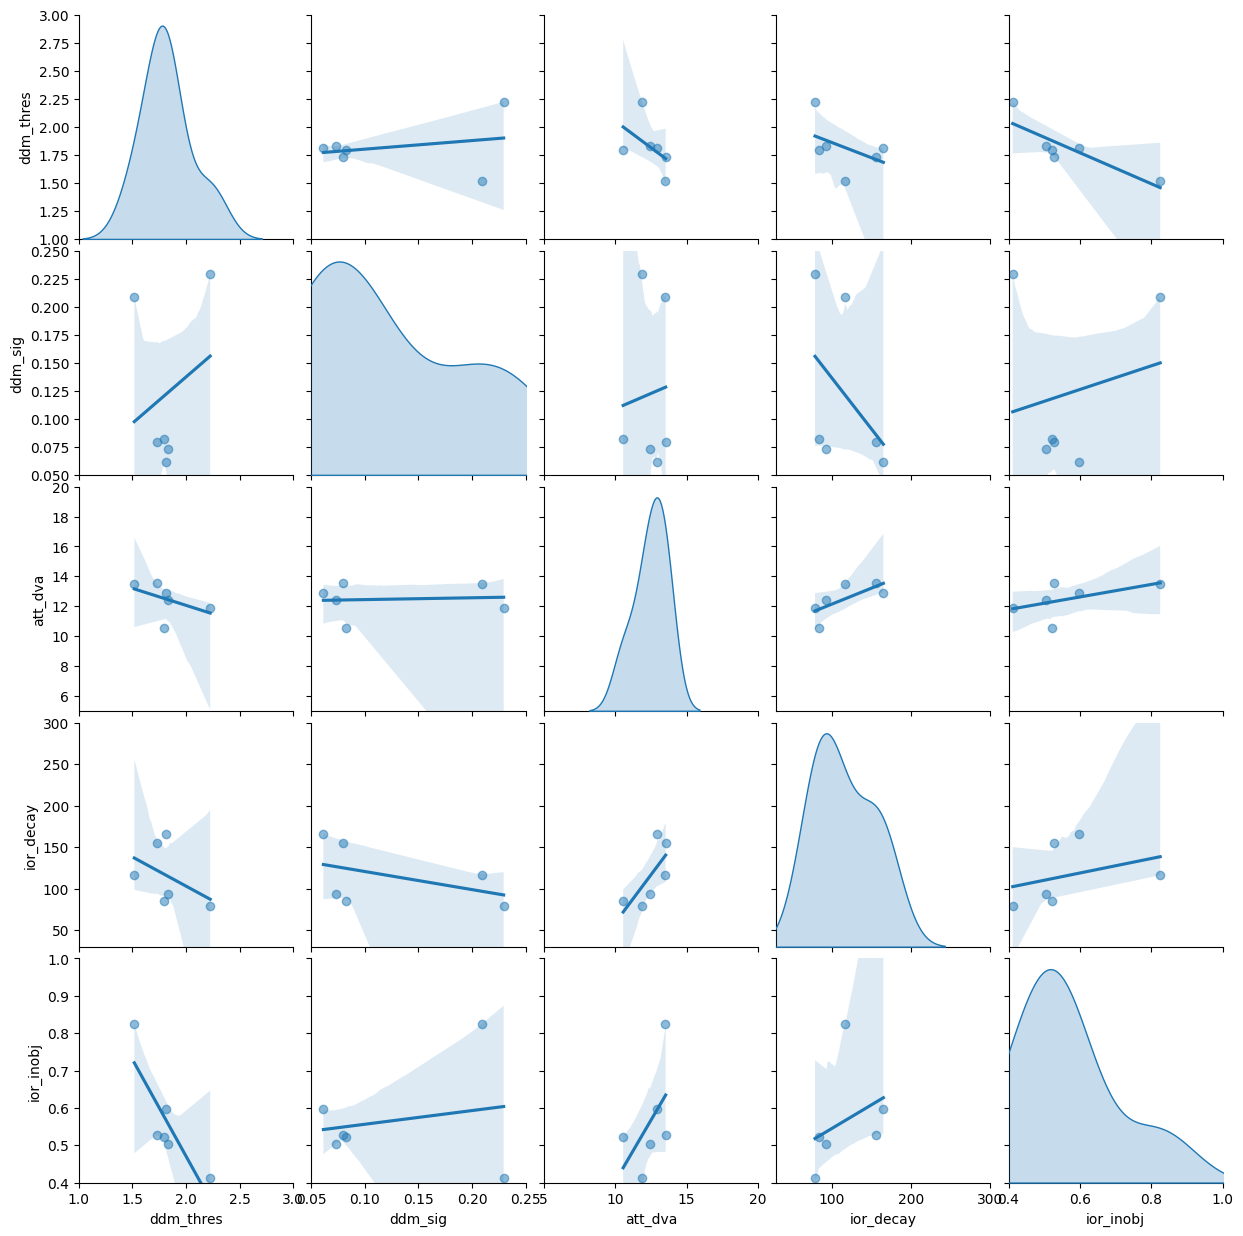

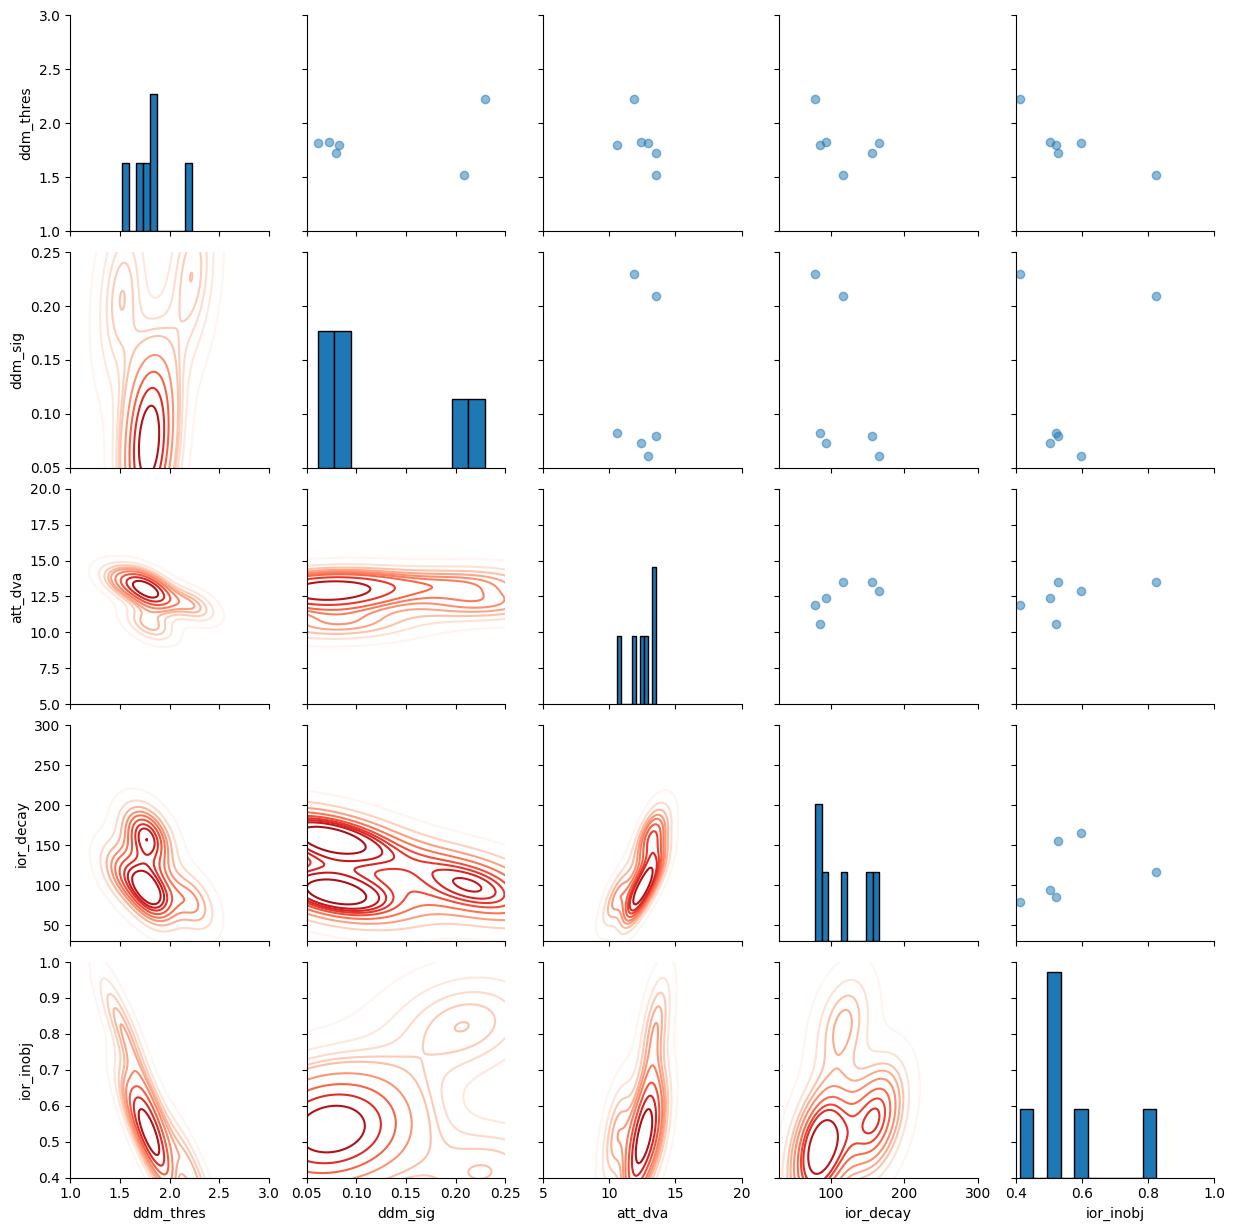

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageS

VID_SIZE_Y=540, VID_SIZE_X=960
VID_SIZE_Y=540, VID_SIZE_X=960Feature maps shape: (150, 540, 960)

Expected frames: 150Feature maps shape: (150, 540, 960)

Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)VID_SIZE_Y=540, VID_SIZE_X=960
Expected frames: 150

Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess pypet INFO     PROGRESS: Finished 13/18 runs [==============      ] 72.2%, remaining: 0:01:53
MainProcess pypet INFO     PROGRESS: Finished 14/18 runs [===============     ] 77.8%, remaining: 0:00:45
MainProcess pypet INFO     PROGRESS: Finished 15/18 runs [================    ] 83.3%, remaining: 0:00:22
MainProcess pypet INFO     PROGRESS: Finished 16/18 runs [=================   ] 88.9%, remaining: 0:00:11
MainProcess pypet INFO     PROGRESS: Finished 17/18 runs [==================  ] 94.4%, remaining: 0:00:04
MainProcess pypet INFO     PROGRESS: Finished 18/18 runs [====================]100.0%
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
***********************************************

----------- Generation 2 -----------
Best individual is [2.2253749492598573, 0.22955232055716351, 11.897475596977442, 79.05965961598832, 0.4118061538107591, 0.6666666666666666, 0.06666666666666667, 5.0, 90.0, 0.19999999999999998]
Score: -0.30217290709460237
Fitness: (0.20643449025150945, 0.3979113239376953)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2025-12-03-07H-57M-01S
Duration of evaluating initial population 0:00:24.737578
Eval function: <function optimize_me at 0x7f2a4ac98040>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 6
Population size: 6
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2a4bcf11b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f2a4b03f7f0>
Selection paramter: 

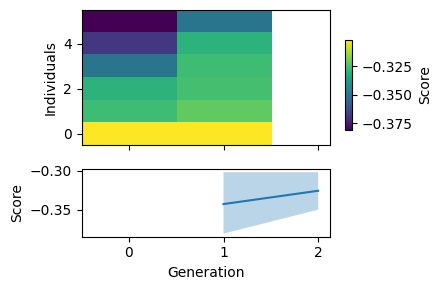

MainProcess root INFO     Saving plot to ./data/figures/results-2025-12-03-07H-57M-01S_hist_2.png


There are 6 valid individuals
Mean score across population: -0.33


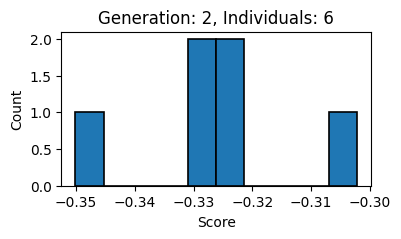

<Figure size 640x480 with 0 Axes>

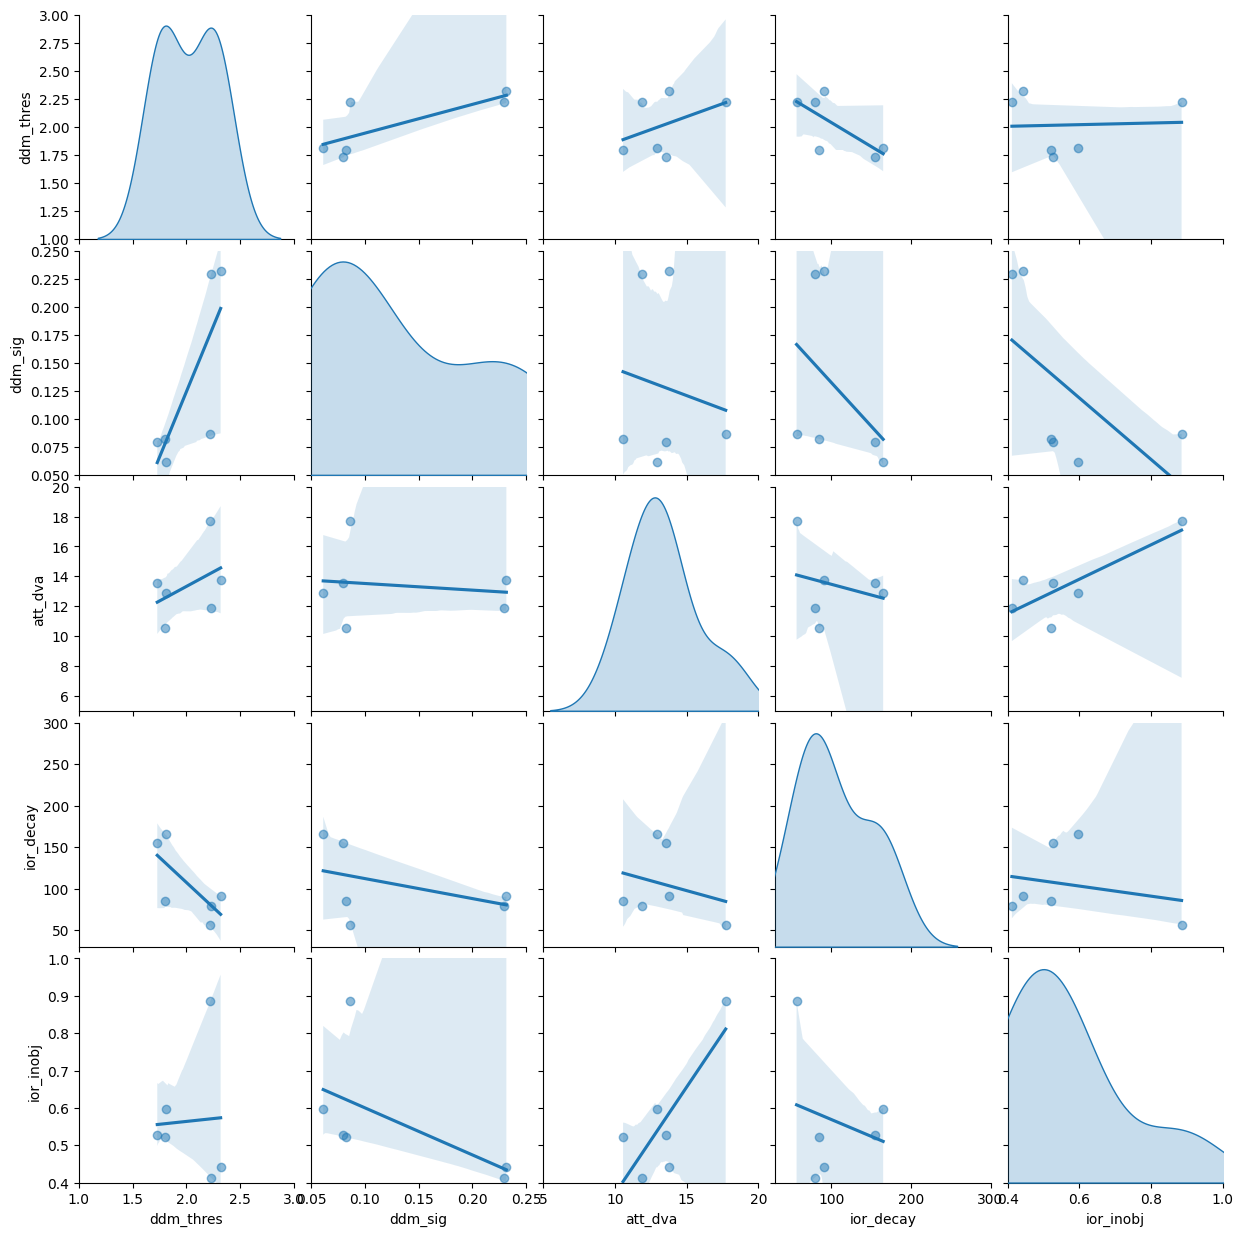

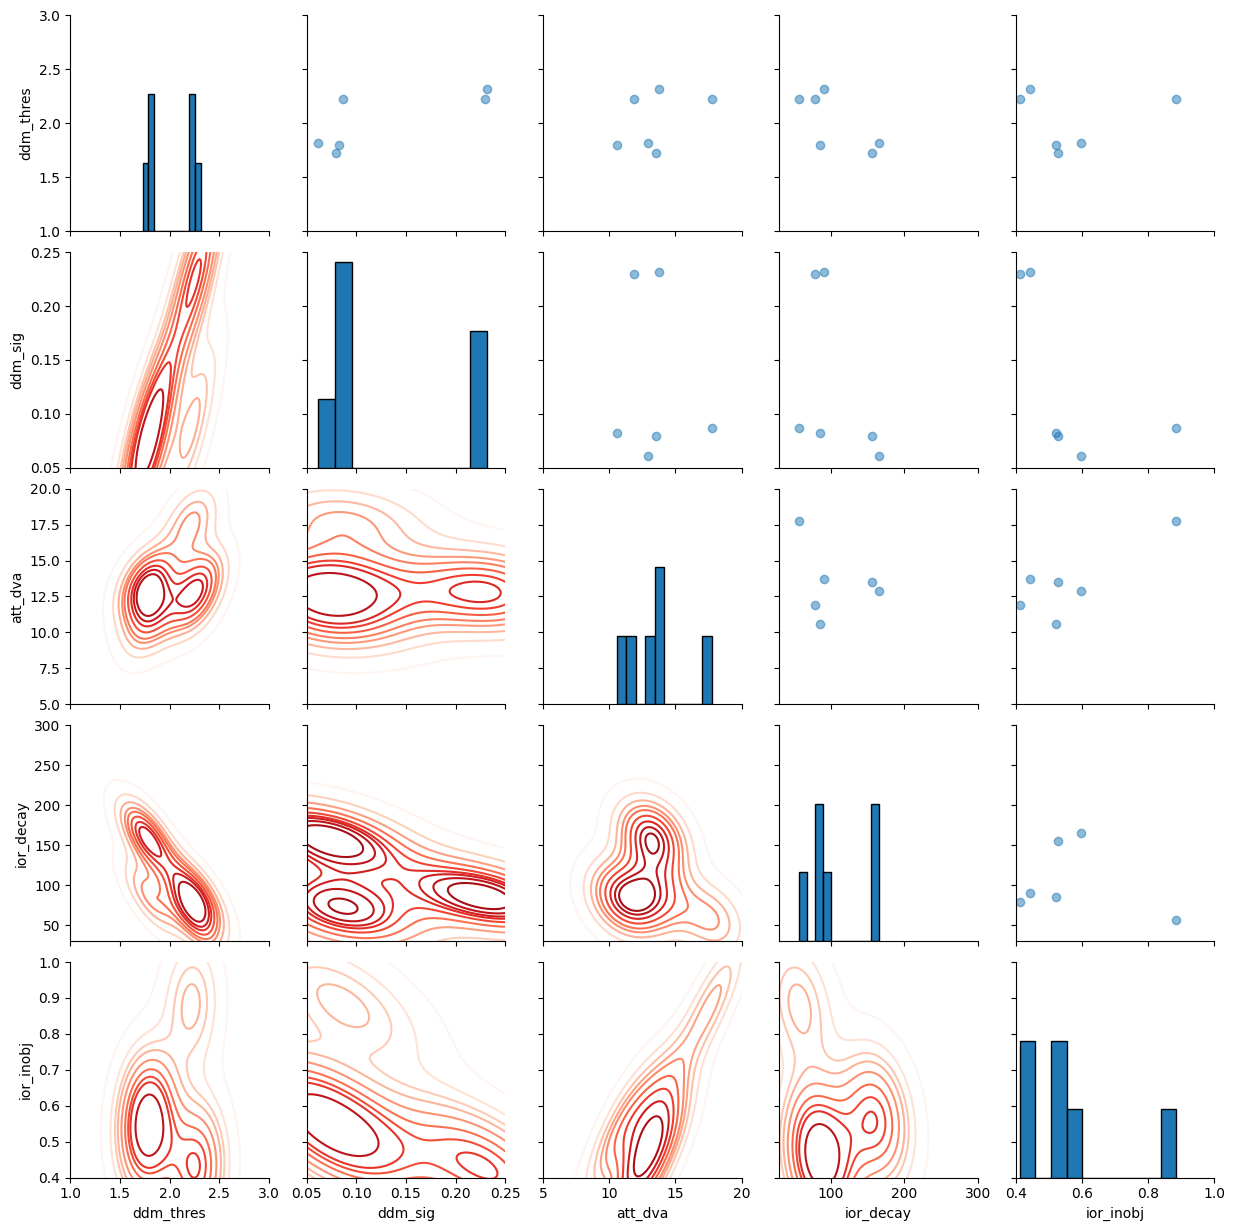

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageS

VID_SIZE_Y=540, VID_SIZE_X=960VID_SIZE_Y=540, VID_SIZE_X=960

Feature maps shape: (150, 540, 960)Feature maps shape: (150, 540, 960)

Expected frames: 150Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960

Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960VID_SIZE_Y=540, VID_SIZE_X=960

Feature maps shape: (150, 540, 960)Feature maps shape: (150, 540, 960)

Expected frames: 150Expected frames: 150



MainProcess pypet INFO     PROGRESS: Finished 20/24 runs [================    ] 83.3%, remaining: 0:00:45
MainProcess pypet INFO     PROGRESS: Finished 21/24 runs [=================   ] 87.5%, remaining: 0:00:22
MainProcess pypet INFO     PROGRESS: Finished 22/24 runs [==================  ] 91.7%, remaining: 0:00:11
MainProcess pypet INFO     PROGRESS: Finished 23/24 runs [=================== ] 95.8%, remaining: 0:00:04
MainProcess pypet INFO     PROGRESS: Finished 24/24 runs [====================]100.0%
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED all runs of trajectory
`results-2025-12-03-07H-57M-01S`.
**************************

----------- Generation 3 -----------
Best individual is [2.2253749492598573, 0.22955232055716351, 11.897475596977442, 79.05965961598832, 0.4118061538107591, 0.6666666666666666, 0.06666666666666667, 5.0, 90.0, 0.19999999999999998]
Score: -0.30217290709460237
Fitness: (0.20643449025150945, 0.3979113239376953)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2025-12-03-07H-57M-01S
Duration of evaluating initial population 0:00:24.737578
Eval function: <function optimize_me at 0x7f2a4ac98040>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 6
Population size: 6
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2a4bcf11b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f2a4b03f7f0>
Selection paramter: 

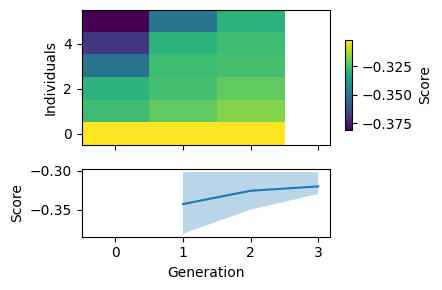

MainProcess root INFO     Saving plot to ./data/figures/results-2025-12-03-07H-57M-01S_hist_3.png


There are 6 valid individuals
Mean score across population: -0.32


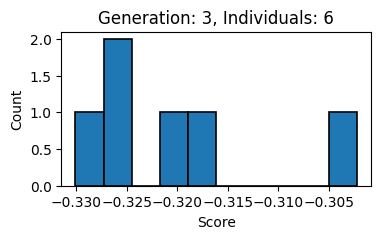

<Figure size 640x480 with 0 Axes>

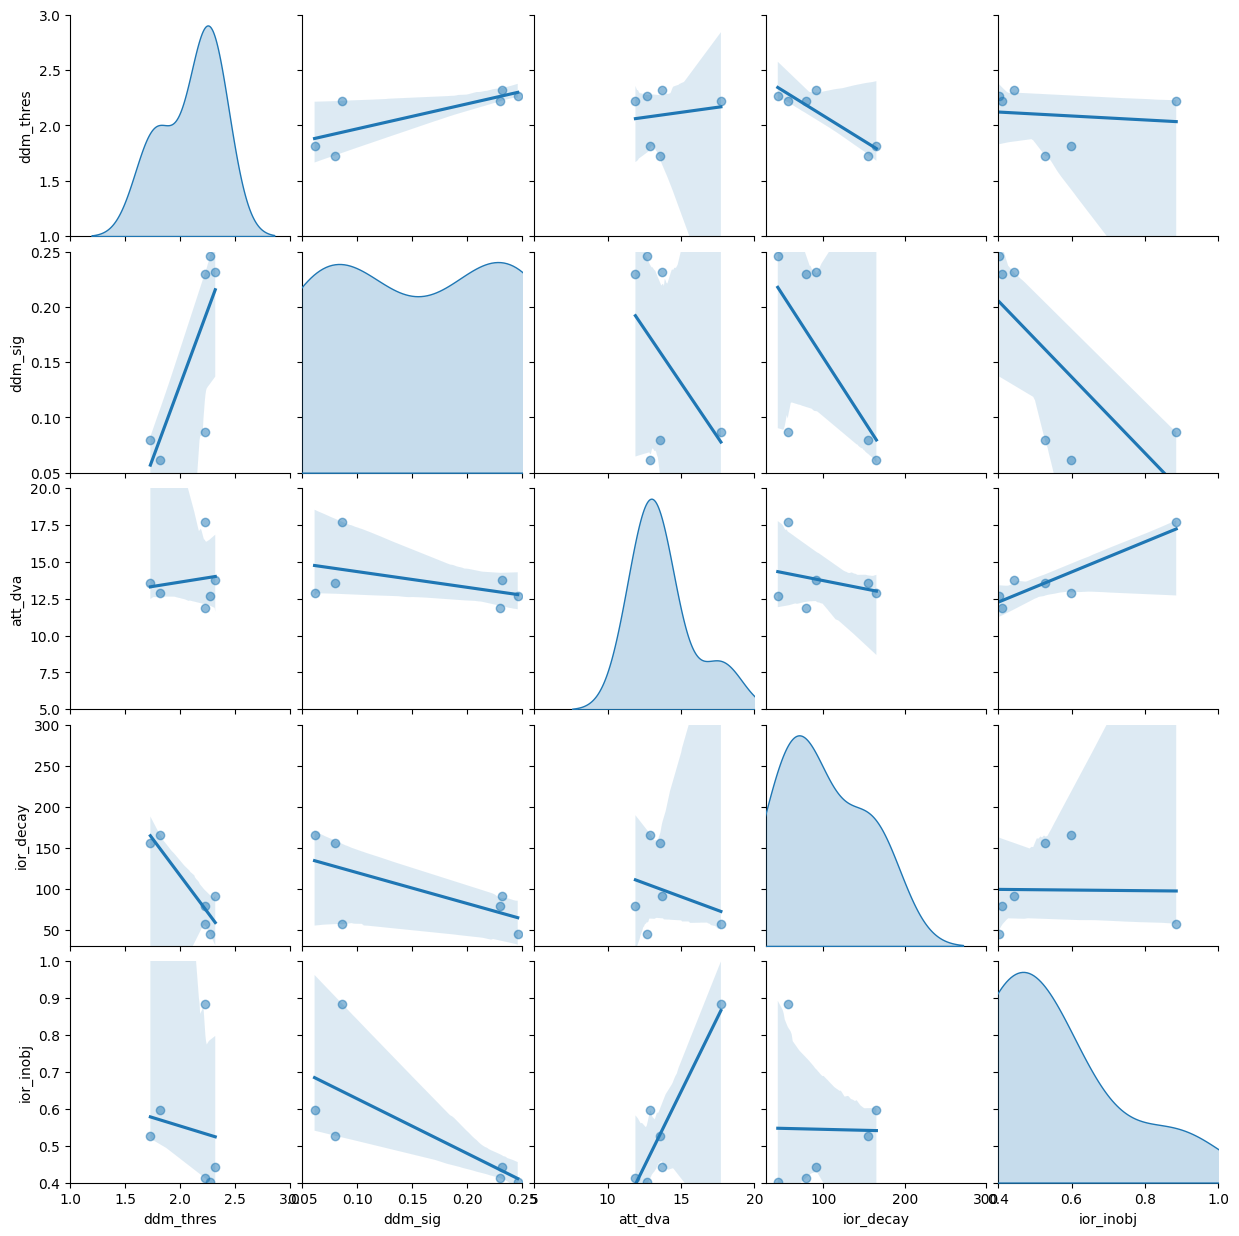

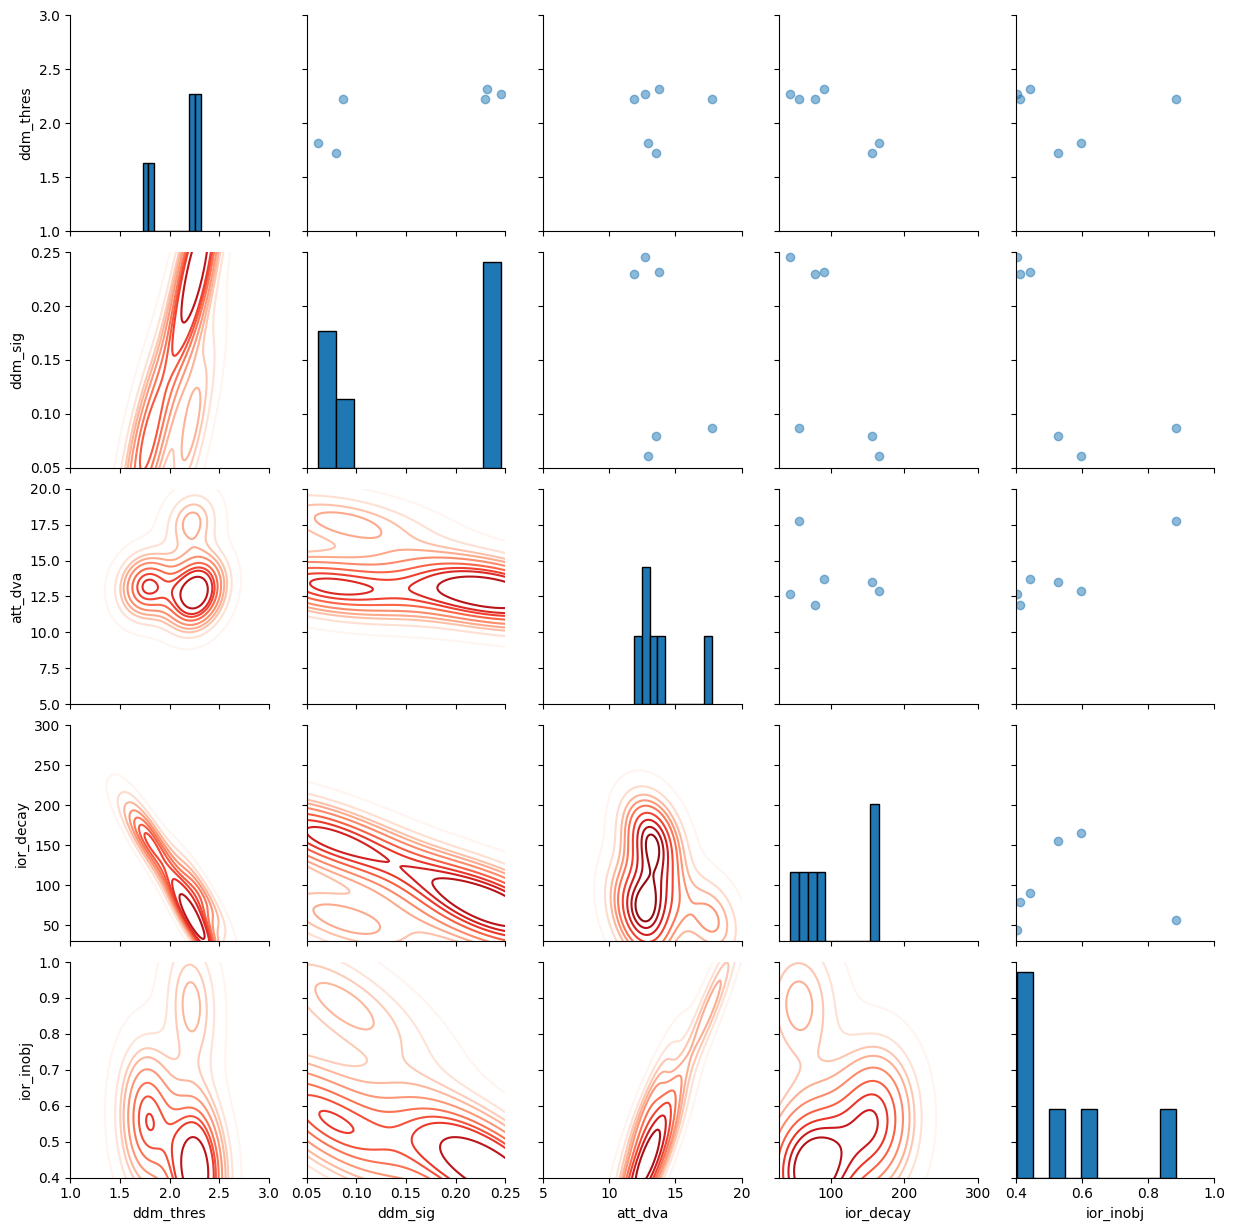

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageS

VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess pypet INFO     PROGRESS: Finished 26/30 runs [=================   ] 86.7%, remaining: 0:00:46
MainProcess pypet INFO     PROGRESS: Finished 27/30 runs [==================  ] 90.0%, remaining: 0:00:23
MainProcess pypet INFO     PROGRESS: Finished 29/30 runs [=================== ] 96.7%, remaining: 0:00:04
MainProcess pypet INFO     PROGRESS: Finished 30/30 runs [====================]100.0%
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED all runs of trajectory
`results-2025-12-03-07H-57M-01S`.
************************************************************

MainProcess pypet.environment.Environment INFO     
******************

----------- Generation 4 -----------
Best individual is [2.2253749492598573, 0.22955232055716351, 11.897475596977442, 79.05965961598832, 0.4118061538107591, 0.6666666666666666, 0.06666666666666667, 5.0, 90.0, 0.19999999999999998]
Score: -0.30217290709460237
Fitness: (0.20643449025150945, 0.3979113239376953)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2025-12-03-07H-57M-01S
Duration of evaluating initial population 0:00:24.737578
Eval function: <function optimize_me at 0x7f2a4ac98040>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 6
Population size: 6
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2a4bcf11b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f2a4b03f7f0>
Selection paramter: 

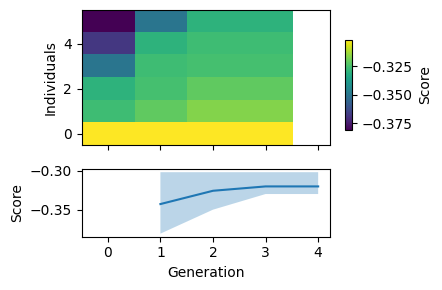

MainProcess root INFO     Saving plot to ./data/figures/results-2025-12-03-07H-57M-01S_hist_4.png


There are 6 valid individuals
Mean score across population: -0.32


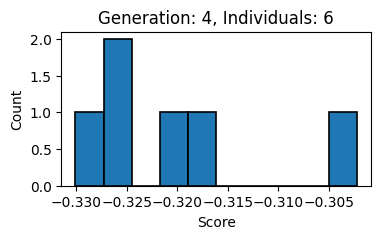

<Figure size 640x480 with 0 Axes>

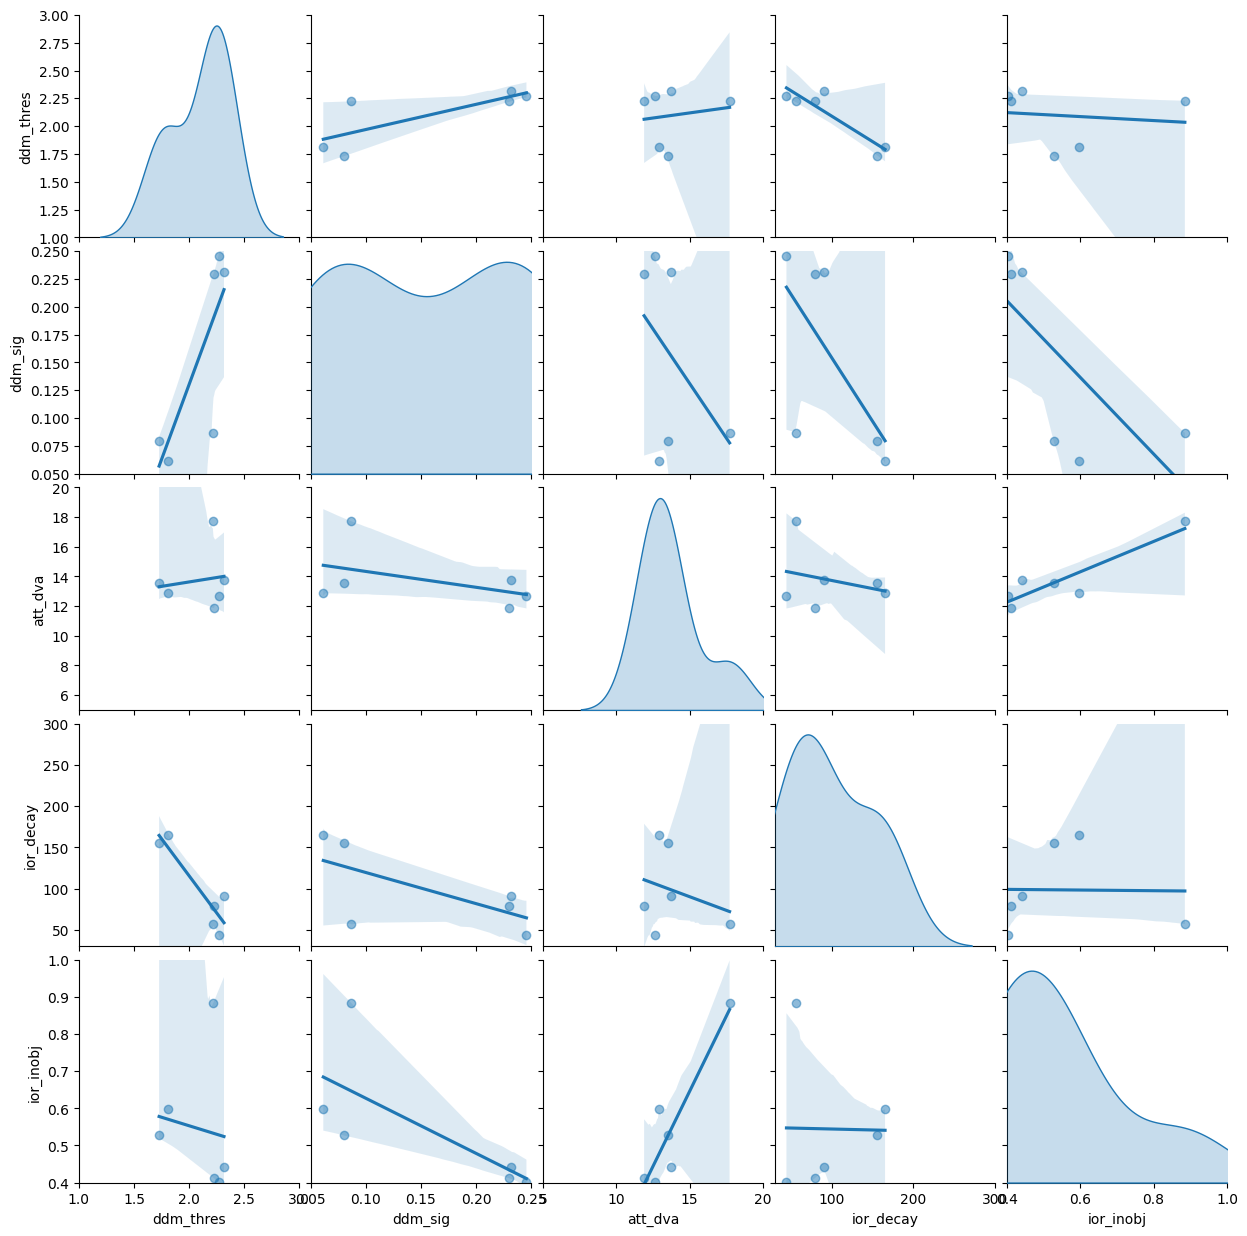

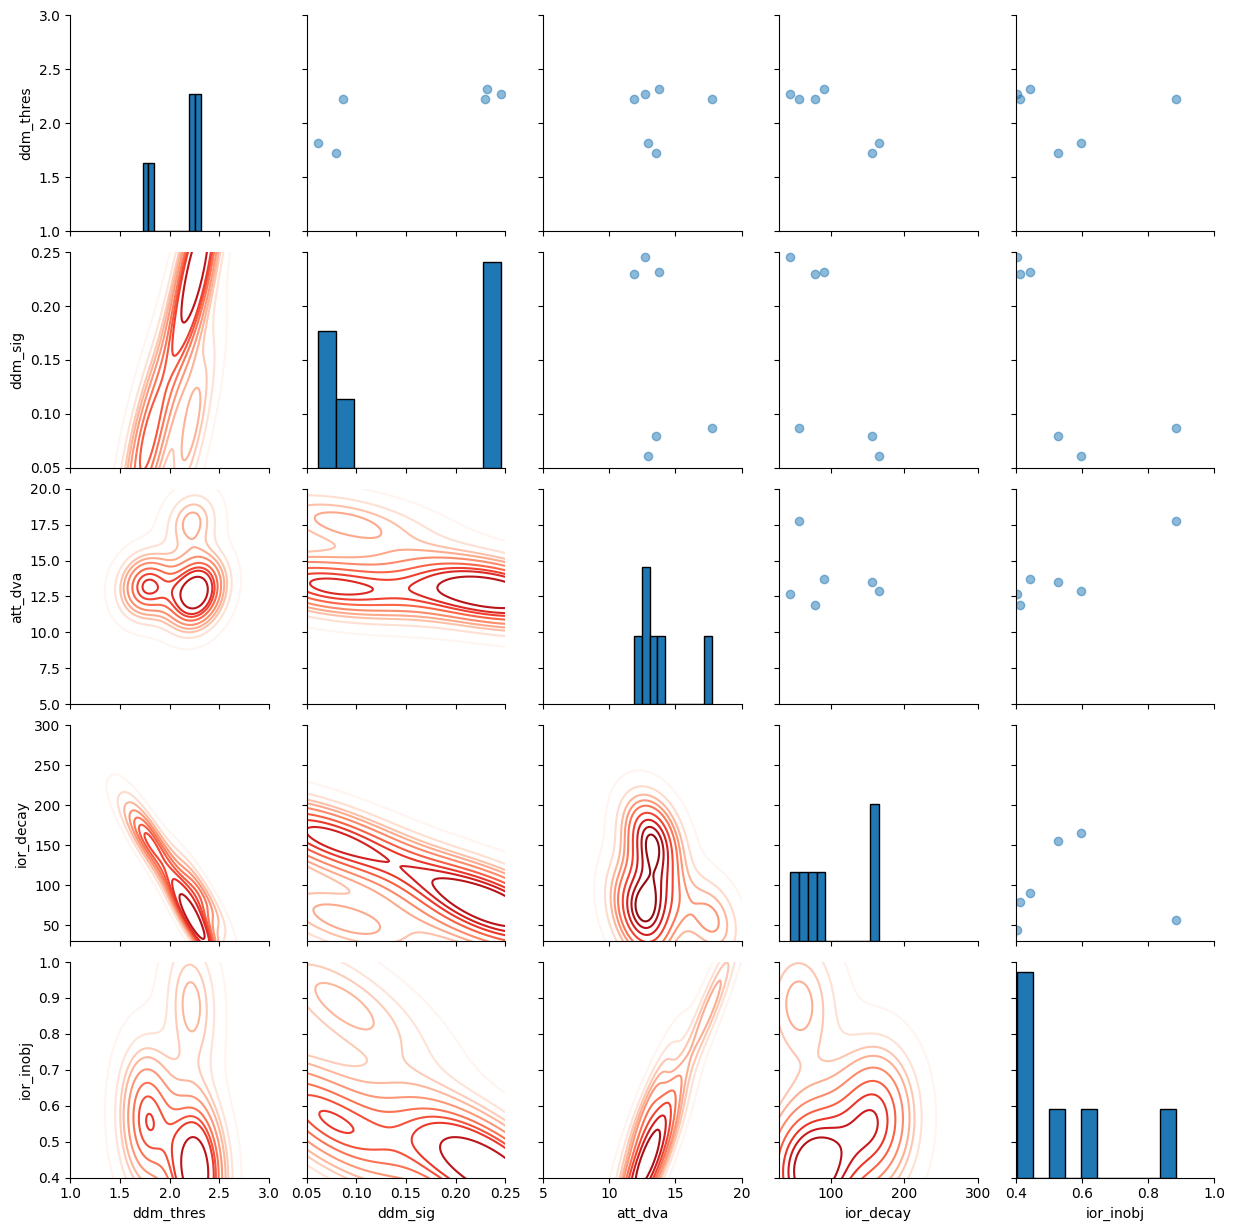

MainProcess root INFO     --- End of evolution ---
MainProcess root INFO     Best individual is [2.2253749492598573, 0.22955232055716351, 11.897475596977442, 79.05965961598832, 0.4118061538107591, 0.6666666666666666, 0.06666666666666667, 5.0, 90.0, 0.19999999999999998], (0.20643449025150945, 0.3979113239376953)
MainProcess root INFO     --- End of evolution ---
MainProcess pypet.storageservice.HDF5StorageService INFO     Start storing Trajectory `results-2025-12-03-07H-57M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `results`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `derived_parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `results-2025-12-03-07H-57M-01S`.


In [ ]:
# verbose means it creates multiple plots for each generation
evolution.run(verbose = True)

Usually, this evolution would be run on all videos of the trainingset, with multiple seeds, higher population sizes and for more generations. Hence, this typically runs best on a high-performance computing cluster.

The results can be saved in a DILL file with the following command:

In [39]:
evolution.saveEvolution("saved_evolution_ex2_obj_sglvid.dill")

MainProcess root INFO     Saving evolution to saved_evolution_ex2_obj_sglvid.dill


## Further analysis / functional evaluation

To actually evaluate how well the simulated scanpaths correspond to human exploration behavior, we recommend to look into the functional scanpath comparison. The basis of this are the ratios of time that are spent in each foveation category, which we saved in this example in the result dictionary. 

The outputs from the evolution in the hdf file can be accessed in in a convenient way as pandas DataFrame:

In [40]:
df_evol = evolution.dfEvolution(outputs=True)
# show the tree best parameter combinations with their fitness score and the stored results 
df_evol.sort_values(by=["score"], ascending=False).iloc[0:3]

,ddm_thres,ddm_sig,att_dva,ior_decay,ior_inobj,score,id,gen,B,D,I,R,f0,f1
12,1.714598,0.198534,6.759657,50.016510,0.980662,-0.249107,12,2,0.813485,0.138724,0.00000,0.047791,0.147863,0.350351
16,2.312803,0.175167,15.097300,32.290199,0.910317,-0.261748,16,2,0.696530,0.246054,0.00000,0.057415,0.261111,0.262385
0,1.999410,0.139252,12.943586,122.203548,0.960904,-0.278697,2,0,0.555142,0.203844,0.05996,0.181054,0.302564,0.254830


For a more in depth analysis of the foveation categories, please refer to the `manuscript_results.ipynb` notebook, where the full analysis is shown in detail.

Try to replicate run_top0.

In [14]:
evolution = evolution.loadEvolution("results/saved_evolution_ex2_obj_sglvid.dill")

MainProcess root INFO     Assuming parameter kind "bound"


In [19]:
df_evol = evolution.dfEvolution(outputs=True).copy()
df_top15 = df_evol.sort_values("score", ascending=False)[:15]

In [ ]:
model = ObjectModel(VidCom)
parameters = ["ddm_thres", "ddm_sig", "att_dva", "ior_decay", "ior_inobj"]
model.params["featuretype"] = "DG2E_cb"

for i in range(32):
    for par in parameters:
                model.params[par] = df_evol.sort_values("score", ascending=False).iloc[i][
                    par
                ] 
    filename = f"results/res_df_top{i}.pkl"
    if os.path.isfile(filename) == False:
        print(f"Running model for top{i} parameter set...")
        model.run('all', seeds=[s for s in range(1, 5)], overwrite_old=True) #range(1,13)
        with open(filename, 'wb') as file:
            pickle.dump(model.result_dict, file)
        df_filename = f"results/res_df_top{i}.csv.gz"
        if os.path.isfile(df_filename) == False:
            model.evaluate_all_to_df()
            model.result_df.to_csv(
                df_filename, compression="gzip", index=False
            )

MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top15 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top16 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top17 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top18 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top19 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top20 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top21 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top22 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top23 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top24 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top25 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top26 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top27 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top28 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top29 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


IndexError: single positional indexer is out-of-bounds

_________________________________________

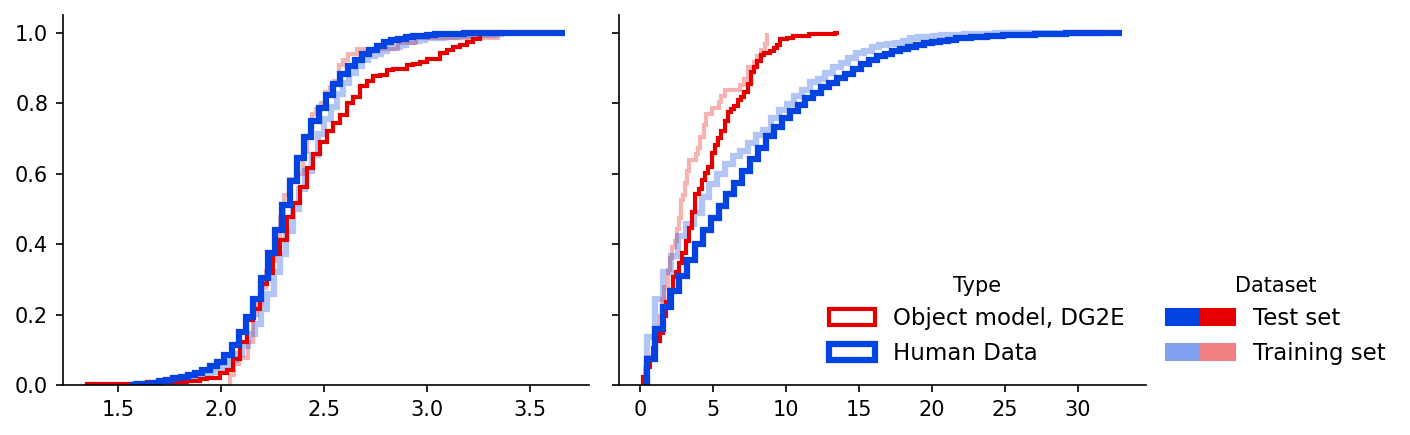

In [ ]:
handles1 = []; handles2 = []
for ind in range(len(mcl)):
    rgb = to_rgb(mcl[ind])
    handles1.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    handles2.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))

fig, axs = plt.subplots(1,2,dpi=150, figsize=(9.5,3), sharey=True)

for modus in ["train", "test"]:
    if modus == "train":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        alpha = 0.3
        idx = 1      # Training = less intensive color
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        alpha = 1.0
        idx = 0      # Test = more intensive color

    gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]

    df_res_object_DG2E_cb_top0 = pd.read_csv('results/res_df_top0.csv.gz', compression='gzip')
    df_res_object_DG2E_cb_top0 = df_res_object_DG2E_cb_top0[df_res_object_DG2E_cb_top0['video'].isin(videoset)]
    obj_hlf_dur_ms = df_res_object_DG2E_cb_top0["duration_ms"].dropna().values 
    obj_hlf_amp_dva = df_res_object_DG2E_cb_top0["sac_amp_dva"].dropna().values 

    nbins = 60

    label_human = 'Human Data' if modus == 'test' else None
    label_model = 'Object model, DG2E' if modus == 'test' else None

    axs[0].hist(np.log10(obj_hlf_dur_ms), nbins, density=True, histtype='step',
                cumulative=True, label=label_model,
                color=mcl[1], lw=2, alpha=alpha)

    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step',
                cumulative=True, label=label_human,
                color=mcl[0], lw=3, alpha=alpha)

    axs[1].hist(obj_hlf_amp_dva, nbins, density=True, histtype='step',
                cumulative=True, label=label_model,
                color=mcl[1], lw=2, alpha=alpha)

    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step',
                cumulative=True, label=label_human,
                color=mcl[0], lw=3, alpha=alpha)

    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])

# 1. Legende: Human vs. Model 
leg1 = axs[1].legend(loc='lower right', frameon=False, title="Type", fontsize=11)

# 2. Legende: Train vs. Test 
leg2 = axs[1].legend(bbox_to_anchor=(1,0), loc='lower left',
                     frameon=False,
                     handles=[tuple(handles1), tuple(handles2)],
                     labels=["Test set", "Training set"],
                     title="Dataset",
                     handlelength=3,
                     handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
                     fontsize=11)

axs[1].add_artist(leg1)  # both legends visible
sns.despine(fig); fig.tight_layout()


# BDI fractions

In [ ]:
print("Fraction of the stimulus time taken up by foveation events in the human data: ", VidCom.get_foveation_ratio())

for i in range(29):
    model = ObjectModel(VidCom, preload_res_df=pd.read_csv(f'results/res_df_top{i}.csv.gz', compression='gzip'))
    print(f"Foveation ratio for {i}: ", model.get_foveation_ratio())

Fraction of the stimulus time taken up by foveation events in the human data:  11.773142727272727
Foveation ratio for 0:  0.9165684775336499
Foveation ratio for 1:  0.9143712592136705
Foveation ratio for 2:  0.9097423749073743
Foveation ratio for 3:  0.9164181220775307
Foveation ratio for 4:  0.8958369156743524
Foveation ratio for 5:  0.885922918198103
Foveation ratio for 6:  0.9124559257049359
Foveation ratio for 7:  0.9097419260328816
Foveation ratio for 8:  0.8971260875999922
Foveation ratio for 9:  0.9255363911571385
Foveation ratio for 10:  0.9018840113671048
Foveation ratio for 11:  0.9079166363437917
Foveation ratio for 12:  0.9305269994320745
Foveation ratio for 13:  0.8893106292649327
Foveation ratio for 14:  0.8925283458313923
Foveation ratio for 15:  0.920342054314091
Foveation ratio for 16:  0.9327174074977859
Foveation ratio for 17:  0.9384398206294646
Foveation ratio for 18:  0.884081269613518
Foveation ratio for 19:  0.9253403268508243
Foveation ratio for 20:  0.92367673

MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2025-12-04-10H-57M-27S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2025-12-04-10H-57M-27S
MainProcess root INFO     Number of cores: 256


MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7f065ef

ddm_thres = $1.936 \pm 0.471$     & 1.715
ddm_sig = $0.164 \pm 0.054$     & 0.199
att_dva = $11.05 \pm 4.15$     & 6.76
ior_decay = $124.1 \pm 71.0$     & 50.0
ior_inobj = $0.73 \pm 0.21$     & 0.98
Balancing of fitness function
$d_{FD} = 0.395 \pm 0.131$   top0: 0.148
$d_{SA} = 0.342 \pm 0.057$   top0: 0.35
Train,  [0.46353857 0.24999644 0.09301216 0.19345284]
Test,  [0.37328606 0.3885739  0.0760649  0.16207514]
Test ratio to GT,  [0.880238   2.88635169 0.25820793 1.10470406]


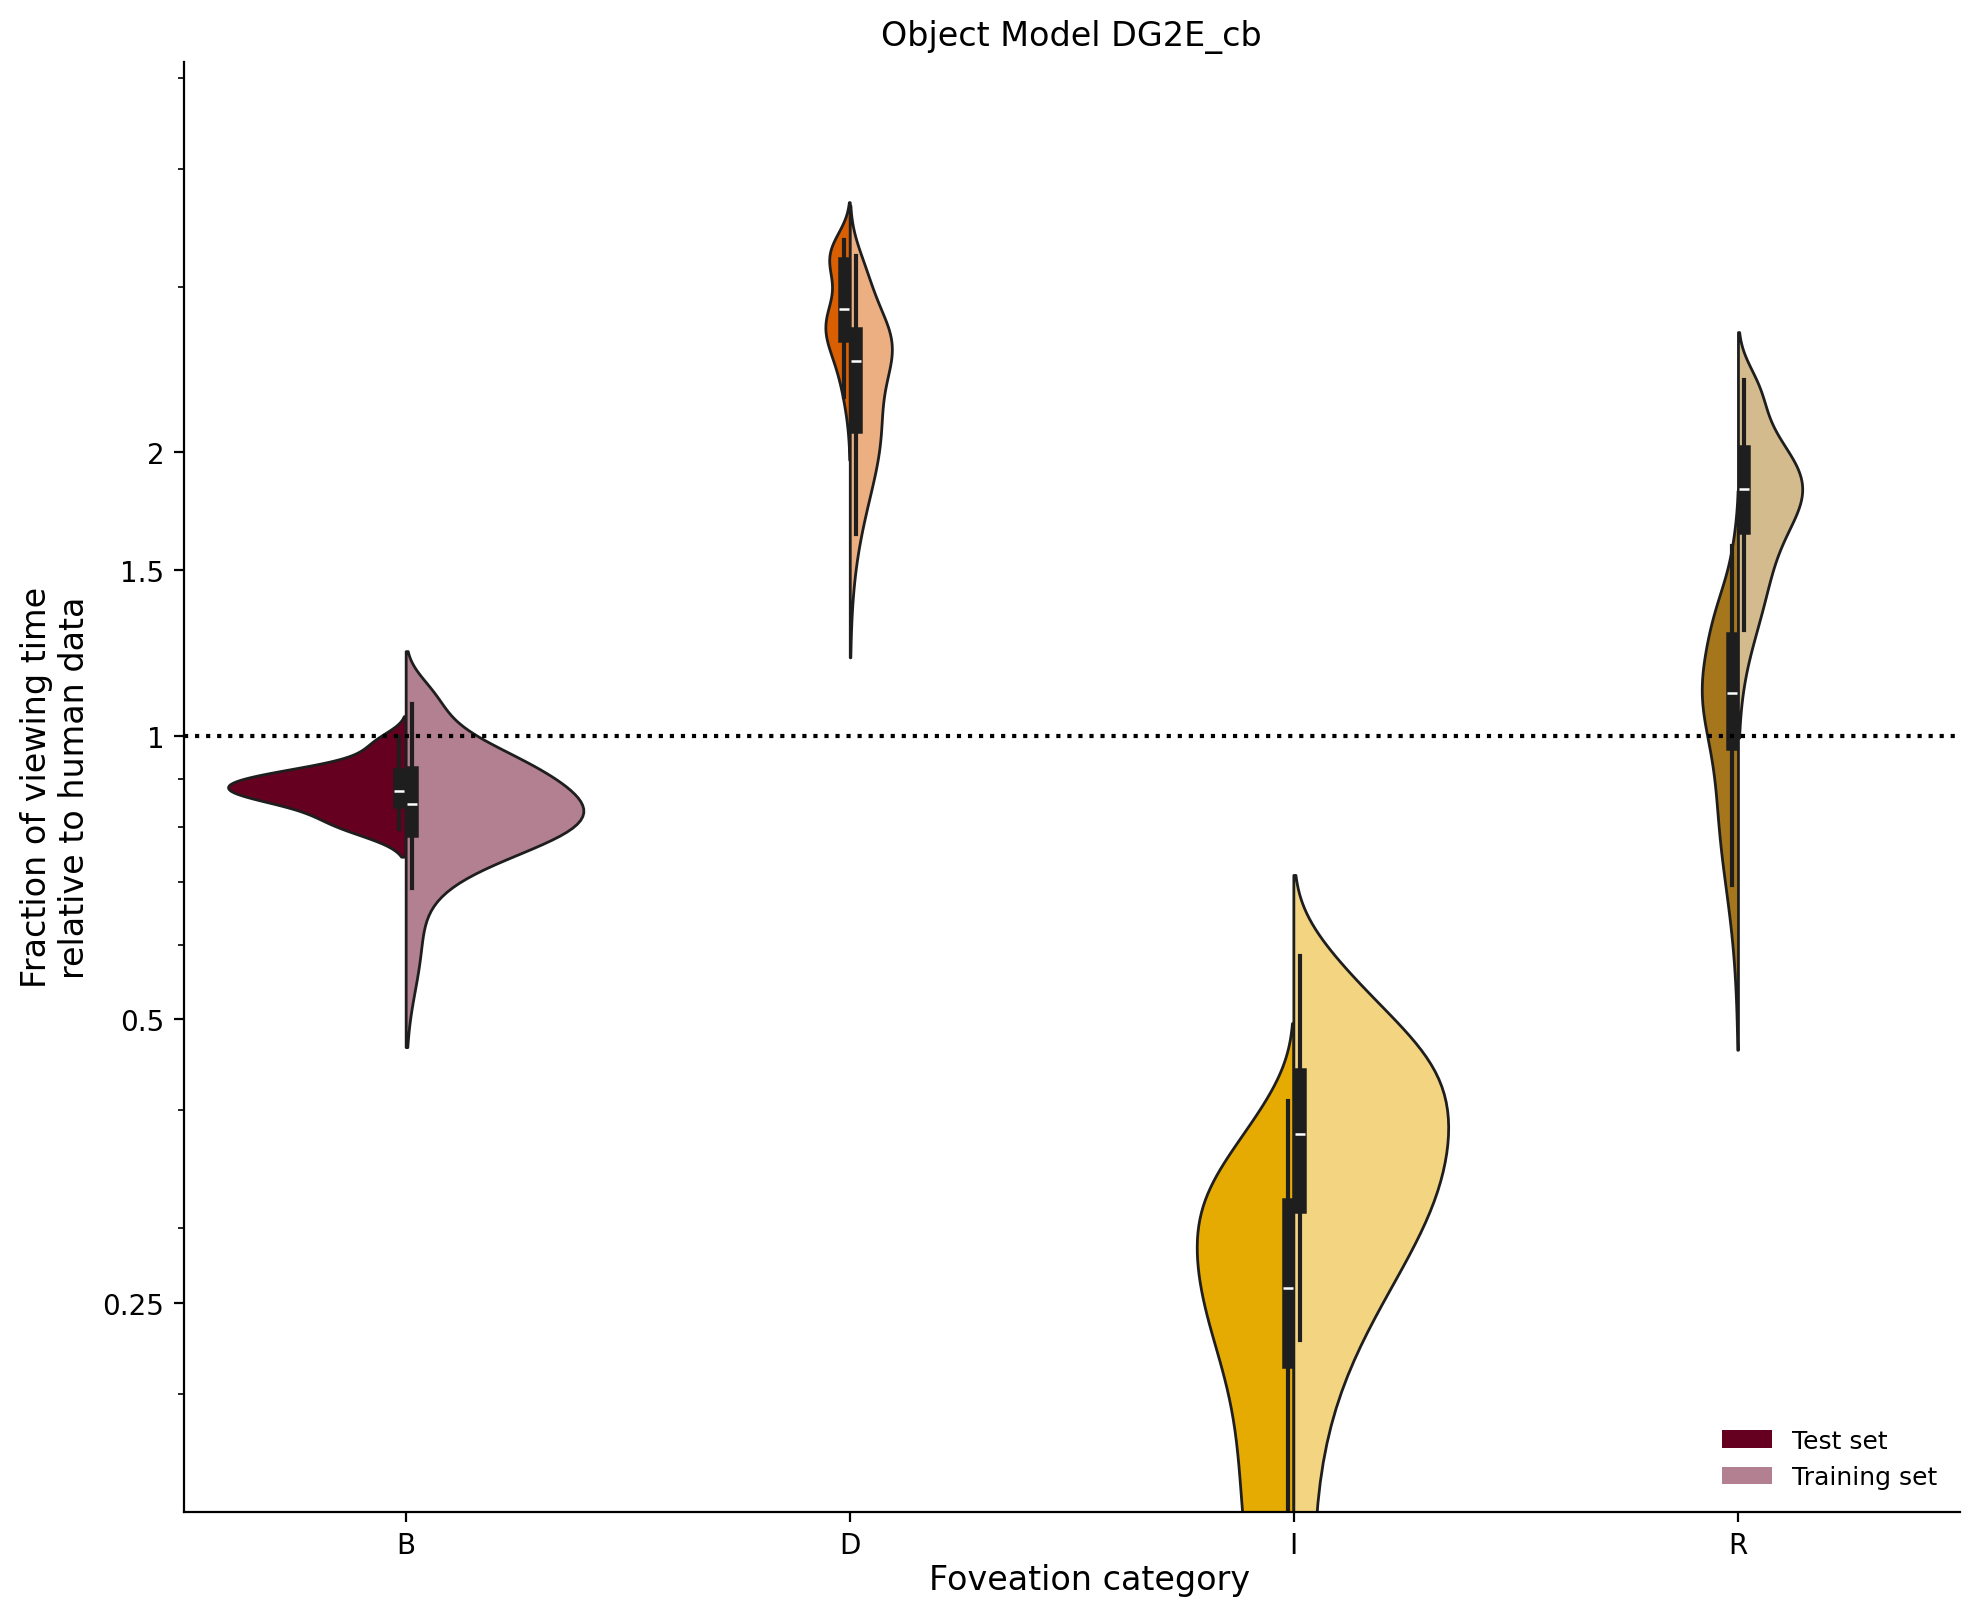

In [26]:
iterations = 29
fig, axes = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,8), dpi=200)
axes = np.array([axes]) #if only 1
report_par_decimals = [3,3,2,1,2]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())

mean_fovcats_train = []
mean_fovcats_test = []

#dummy evol overwriten later
evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    DILLNAME = f'saved_evolution_ex2_obj_sglvid.dill'
    model = ObjectModel(VidCom)
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']

    evol = evol.loadEvolution(f'results/{DILLNAME}') #overwrite dummy evol
    df_evol = evol.dfEvolution(outputs=True).copy()
    #df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    df_top = df_evol.sort_values('score', ascending=False)[:iterations]

    train_fovcats = []
    test_fovcats = []
    #for i in range(32):
    for i in range(iterations):
        df_res = pd.read_csv(f'results/res_df_top{i}.csv.gz', compression='gzip')
        model.result_df = df_res[df_res['video'].isin(VidCom.trainset)]
        train_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
        model.result_df = df_res[df_res['video'].isin(VidCom.testset)]
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    #df_top32['train_fov_cat'] = train_fovcats
    #df_top32['test_fov_cat'] = test_fovcats
    df_top['train_fov_cat'] = train_fovcats
    df_top['test_fov_cat'] = test_fovcats

    for i, par in enumerate(parameters):
        top_par = round(df_top[par].iloc[0],report_par_decimals[i])
        print(f'{par} = ${round(df_top[par].mean(),report_par_decimals[i])} \pm {round(df_top[par].std(),report_par_decimals[i])}$     & {top_par}' )
    print("Balancing of fitness function")
    print("$d_{FD} =", f'{round(df_top["f0"].mean(), 3)} \pm {round(df_top["f0"].std(), 3)}$   top0: {round(df_top["f0"].iloc[0], 3)}' )
    print("$d_{SA} =", f'{round(df_top["f1"].mean(), 3)} \pm {round(df_top["f1"].std(), 3)}$   top0: {round(df_top["f1"].iloc[0], 3)}' )


    fovcats_train = [df_top['train_fov_cat'].iloc[indv] for indv in range(iterations)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top['train_fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(iterations)]
    
    fovcats_test = [df_top['test_fov_cat'].iloc[indv] for indv in range(iterations)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ",  np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ",  np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(iterations)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(iterations)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='training set')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(iterations)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='test set')
    cdf = pd.concat([df_test_fovcats_rel_gt, df_train_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name='fov_cat')

    sns.violinplot(x="fov_cat", y="value", hue="Data", data=mdf, ax=ax, split=True, linewidth=1, palette={"test set": dircl[0], "training set": ".85"})    
    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(dircl[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    ax.set_yscale('log')
    #ax.set_ylim(0.15, 2.2)
    ax.set_ylim(0.15, 5.2)
    ax.set_yticks([0.25,0.5,1,1.5,2])
    ax.set_yticklabels([0.25,0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')

    if ax_i==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    if ax_i == (len(axes.flat) - 1):
        legend_handles = [
            Patch(facecolor=to_rgb(dircl[0]), edgecolor='none', label="Test set"),
            Patch(facecolor=0.5 + 0.5*np.array(to_rgb(dircl[0])), edgecolor='none', label="Training set")
        ]
        ax.legend(
            bbox_to_anchor=(1, 0), loc='lower right',
            frameon=False,
            handles=legend_handles,
            title="", fontsize=9
        )
    else:
        ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_title('Object Model DG2E_cb')
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine(); plt.show()

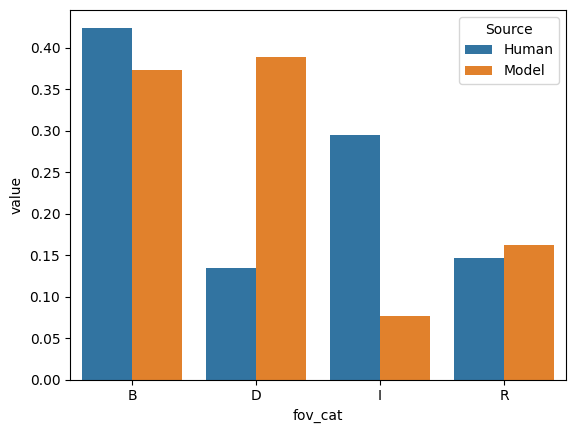

In [54]:
df_human = pd.DataFrame([subjects_fovcat_test], columns=['B','D','I','R']).assign(Source='Human')

model_test = np.mean(np.array(test_fovcats), axis=0)
df_model = pd.DataFrame([model_test], columns=['B','D','I','R']).assign(Source='Model')

cdf = pd.concat([df_human, df_model])
mdf = pd.melt(cdf, id_vars='Source', var_name='fov_cat')
sns.barplot(x="fov_cat", y="value", hue="Source", data=mdf)
plt.show()

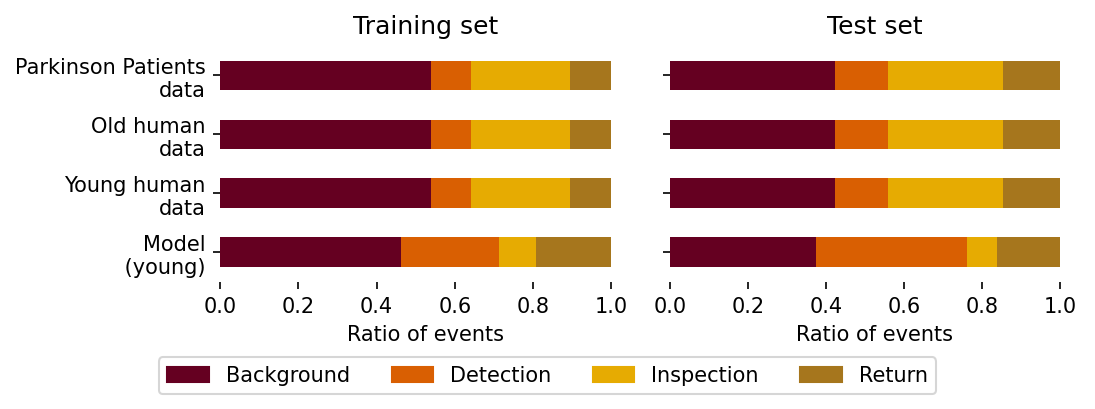

In [ ]:
import matplotlib.patches as mpatches
# Extract the single arrays from the lists
mean_fovcat_train = mean_fovcats_train[0] 
mean_fovcat_test = mean_fovcats_test[0]    

# Get human data
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())

# Create DataFrames with proper column names for BDIR categories
df_fovcats_train = pd.DataFrame(
    index=['Model \n (young)', 'Young human\ndata', 'Old human\ndata', 'Parkinson Patients\ndata'], 
    columns=['B', 'D', 'I', 'R'],
    data=[mean_fovcat_train, subjects_fovcat_train, subjects_fovcat_train, subjects_fovcat_train]
)

df_fovcats_test = pd.DataFrame(
    index=['Model\n (young)', 'Young human\ndata', 'Old human\ndata', 'Parkinson Patients\ndata'], 
    columns=['B', 'D', 'I', 'R'],
    data=[mean_fovcat_test, subjects_fovcat_test, subjects_fovcat_test, subjects_fovcat_test]
)


legend_handles = [
    mpatches.Patch(color=dircl[0], label='Background'),
    mpatches.Patch(color=dircl[1], label='Detection'),
    mpatches.Patch(color=dircl[2], label='Inspection'),
    mpatches.Patch(color=dircl[3], label='Return'),
]

fig, axes = plt.subplots(1, 2, figsize=(7.4, 2.5), dpi=150, sharey=True)

# Plot training set
df_fovcats_train.plot.barh(
    stacked=True, ax=axes[0], rot=0, legend=False, color=dircl
)
axes[0].set_frame_on(False)
axes[0].set_xlabel('Ratio of events')
axes[0].set_title('Training set')

# Plot test set
df_fovcats_test.plot.barh(
    stacked=True, ax=axes[1], rot=0, legend=False, color=dircl
)
axes[1].set_frame_on(False)
axes[1].set_xlabel('Ratio of events')
axes[1].set_title('Test set')

fig.legend(
    handles=legend_handles,
    loc='lower center',     
    ncol=4,                 
    bbox_to_anchor=(0.5, -0.1)
)


plt.tight_layout()
plt.show()
